## Elasticsearch performance tests

This is a simple notebook which evaluates time performance of elasticsearch requests using different document sizes and different requests. The following tests were run creating indexes and indexing data with sizes of 10K, 20K, 30K, 50K and 100K documents:
- Basic query "match_all" without filters.
- Geo shape filtered query.
- Geo shape filtered query with heatmap facetting.
- "match_all" query with heatmap facetting.

## Functions definitions.

In [41]:
# Create elasticsearch connection.
import rawes
es = rawes.Elastic('http://localhost:9200')
global_query = {
    "query": {
        "match_all": {}
    }
}
geoshape_filter = {
  "bool": {
    "filter": {
      "geo_shape": {
        "layer_geoshape": {
          "shape": {
            "type": "envelope", 
            "coordinates": [
              ["-180.0", "90.0"], 
              ["180.0", "-90.0"]
            ]
          }, 
          "relation": "intersects"
        }
      }
    }
  }
}
heatmap_agg = {
  "viewport": {
    "heatmap": {
      "dist_err_pct": 0.07, 
      "field": "layer_geoshape", 
      "geom": {
        "geo_shape": {
          "layer_geoshape": {
            "shape": {
              "type": "envelope", 
              "coordinates": [
                ["-180.0", "90.0"], 
                ["180.0", "-90.0"]
              ]
            }, 
            "relation": "within"
          }
        }
      }
    }
  }
}

def p_hr():
    print "==============================================================="

def l_hr():
    print "---------------------------------------------------------------"    

In [2]:
def basic_query(index_name):
    query = global_query.copy()
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [3]:
def filtered_geoshape_query(index_name):
    query = global_query.copy()
    query['query'] = geoshape_filter
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [4]:
def heatmap_aggregation(index_name):    
    query = global_query.copy()
    query['query'] = geoshape_filter
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [5]:
def heatmap_aggregation_nofilter(index_name):    
    query = global_query.copy()
    query['aggs'] = heatmap_agg
    url = '/%s/_search' % (index_name)
    response = es.post(url, data=query)
    
    return response

In [57]:
def test_performance(index_name):
    time_list = []
    p_hr()
    print "Test performance for %s" % (index_name)
    p_hr()
    
    print "\nBasic Query"
    l_hr()
    response = basic_query(index_name)
    print 'Total number of records: %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])    

    print "Geoshape filtering query"
    l_hr()
    response = filtered_geoshape_query(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took']) 

    print "Heatmap aggregation query"
    l_hr()
    response = heatmap_aggregation(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs\n' % response['took']
    time_list.append(response['took'])

    print "Heatmap aggregation without filter query"
    l_hr()
    response = heatmap_aggregation_nofilter(index_name)
    print 'Total records %d' % response['hits']['total']
    print 'Response time %d msecs' % response['took']
    time_list.append(response['took'])
    
    return time_list

### 1. Experiments with 10k documents

#### a. Create and index documents with mapping...using bash

In [6]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_10k -d @mapping.json
print '\nIndexing documents...'
!time curl --silent -XPOST http://localhost:9200/index_10k/layer/_bulk --data-binary @data_es/scroll_0001.json > /dev/null
times_10k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m19.611s
user	0m0.018s
sys	0m0.062s


{u'_shards': {u'failed': 0, u'successful': 5, u'total': 10}}

#### b. Test performance

In [53]:
time_10k = test_performance('index_10k')

Test performance for index_10k

Basic Query
---------------------------------------------------------------
Total number of records: 10000
Response time 5 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 10000
Response time 10 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 10000
Response time 33 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 10000
Response time 39 msecs


### 2. Experiments with 20k documents

#### a. Create and index documents with mapping...using bash

In [11]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_20k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 2 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_20k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_20k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m34.303s
user	0m0.048s
sys	0m0.158s


{u'_shards': {u'failed': 0, u'successful': 10, u'total': 20}}

#### b. Test performance

In [54]:
time_20k = test_performance('index_20k')

Test performance for index_20k

Basic Query
---------------------------------------------------------------
Total number of records: 10000
Response time 11 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 20000
Response time 192 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 20000
Response time 750 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 20000
Response time 24 msecs


### 3. Experiments with 30k documents

#### a. Create and index documents with mapping...using bash

In [16]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_30k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 3 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_30k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_30k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	0m45.001s
user	0m0.064s
sys	0m0.240s


{u'_shards': {u'failed': 0, u'successful': 15, u'total': 30}}

#### b. Test performance

In [56]:
time_30k = test_performance('index_30k')

Test performance for index_30k

Basic Query
---------------------------------------------------------------
Total number of records: 10000
Response time 10 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 30000
Response time 8 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 30000
Response time 51 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 30000
Response time 36 msecs


### 4. Experiments with 50k documents

#### a. Create and index documents with mapping...using bash

In [21]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_50k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 5 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_50k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_50k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	1m12.178s
user	0m0.112s
sys	0m0.402s


{u'_shards': {u'failed': 0, u'successful': 20, u'total': 40}}

#### b. Test performance

In [58]:
time_50k = test_performance('index_50k')

Test performance for index_50k

Basic Query
---------------------------------------------------------------
Total number of records: 50000
Response time 154 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 50000
Response time 188 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 50000
Response time 1602 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 50000
Response time 36 msecs


### 5. Experiments with 100k documents

#### a. Create and index documents with mapping...using bash

In [26]:
print 'Creating index...'
!curl -XPUT http://localhost:9200/index_100k -d @mapping.json
print '\nIndexing documents...'
!time ls data_es | head -n 10 | xargs -I{} sh -c "curl --silent -XPOST http://localhost:9200/index_100k/layer/_bulk \
                                    --data-binary @data_es/{} > /dev/null"
times_100k = []
es.post('/_refresh')

Creating index...
{"acknowledged":true,"shards_acknowledged":true}
Indexing documents...

real	2m1.630s
user	0m0.212s
sys	0m0.738s


{u'_shards': {u'failed': 0, u'successful': 25, u'total': 50}}

#### b. Test performance

In [59]:
time_100k = test_performance('index_100k')

Test performance for index_100k

Basic Query
---------------------------------------------------------------
Total number of records: 100000
Response time 136 msecs

Geoshape filtering query
---------------------------------------------------------------
Total records 100000
Response time 300 msecs

Heatmap aggregation query
---------------------------------------------------------------
Total records 100000
Response time 2267 msecs

Heatmap aggregation without filter query
---------------------------------------------------------------
Total records 100000
Response time 118 msecs


Populating the interactive namespace from numpy and matplotlib


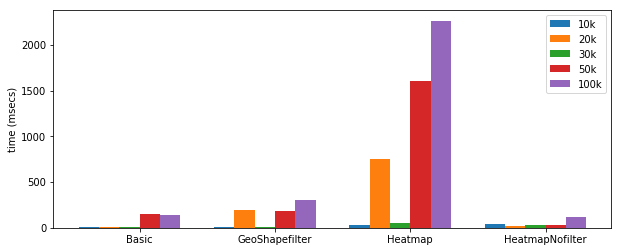

In [103]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

import numpy as np
from matplotlib import pyplot as plt

N = 4
ind = np.arange(N)
width = 0.15
fig, ax = plt.subplots()
rects_10k = ax.bar(ind, time_10k, width)
rects_20k = ax.bar(ind + width, time_20k, width)
rects_30k = ax.bar(ind + 2*width, time_30k, width)
rects_50k = ax.bar(ind + 3*width, time_50k, width)
rects_100k = ax.bar(ind + 4*width, time_100k, width)

ax.set_ylabel('time (msecs)')
ax.set_xticks(ind + 2.5*width)
ax.set_xticklabels(('Basic', 'GeoShapefilter', 'Heatmap', 'HeatmapNofilter'))

legend_tuple = (rects_10k[0], rects_20k[0], rects_30k[0], rects_50k[0], rects_100k[0])
legend_names = ('10k', '20k', '30k', '50k', '100k')
ax.legend(legend_tuple, legend_names)


plt.show()